In [229]:
import folium
import pandas as pd

def convert_to_float(value):
    if value == 'Sem Informações':
        return value
    return float(value)

# Carregue os dados do arquivo CSV
a = pd.read_csv('./registroB_organizado.csv', sep=',')

# Filtrar registros com datas após 2012
a['Data do registro'] = pd.to_datetime(a['Data do registro'], format='%d/%m/%Y')
a = a[a['Data do registro'].dt.year >= 2012]

# Converter as colunas de Latitude e Longitude para float, exceto "Sem Informações"
a['Latitude'] = a['Latitude'].apply(convert_to_float)
a['Longitude'] = a['Longitude'].apply(convert_to_float)

# Filtrar "Sem Informações"
a_filtered = a[(a['Latitude'] != 'Sem Informações') & (a['Longitude'] != 'Sem Informações')]

# Criar o mapa
mapa = folium.Map(location=[a_filtered['Latitude'].mean(), a_filtered['Longitude'].mean()], zoom_start=6)

# Contagem de "Sem Informações"
sem_informacoes = a[(a['Latitude'] == 'Sem Informações') | (a['Longitude'] == 'Sem Informações')].shape[0]

# Adicionar círculo cinza com popup da contagem de "Sem Informações"
folium.Marker(
    location=[-12.9711, -38.5108],
    popup=f"Salvador-SB <br>Pontos Sem Informações: {sem_informacoes}",
    icon=folium.Icon(color='blue') 
).add_to(mapa)
# Adicionar pequenos círculos para cada endereço com borda preta
for index, row in a_filtered.iterrows():
    # Cria um círculo pequeno para cada endereço
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,  # Defina o raio do círculo pequeno (em pixels)
        color='yellow',  # Cor do círculo pequeno
        fill=True,
        fill_color='yellow',
        fill_opacity=0.4,
        weight=1,
        popup=f"Nome Comum: {row['Nome comum']}<br>Latitude: {row['Latitude']}<br>Longitude: {row['Longitude']}"
    ).add_to(mapa)

# Exibir o mapa interativo
mapa


ORGANIZADOR DE DADOS CSV

In [223]:
def organizar_lat_long(latitude, longitude):
    # Verificar se os valores são "sem informações" e retorná-los sem alterações
    if latitude.lower() == "sem informações" or longitude.lower() == "sem informações":
        return latitude, longitude

    # Remover todos os pontos das latitudes e longitudes
    latitude = latitude.replace('.', '')
    longitude = longitude.replace('.', '')

    if not latitude.startswith('-'):
        latitude = '-' + latitude
    if not longitude.startswith('-'):
        longitude = '-' + longitude
    # Adicionar o '.' após o terceiro caracter, se houver pelo menos três caracteres
    if len(latitude) >= 3:
        latitude = latitude[:3] + '.' + latitude[3:]
    if len(longitude) >= 3:
        longitude = longitude[:3] + '.' + longitude[3:]

    
    if -39.00 <= float(latitude) <= -37.00:
        return longitude, latitude  # Inverter latitude e longitude
    else:
        return latitude, longitude

    return latitude, longitude

# Ler o arquivo CSV
df = pd.read_csv('registroB.csv', sep=',')

# Aplicar a função de organização de latitude e longitude para cada linha do DataFrame
df['Latitude'], df['Longitude'] = zip(*df.apply(lambda row: organizar_lat_long(row['Latitude'], row['Longitude']), axis=1))

# Remover espaços em branco das colunas Latitude e Longitude, exceto para a opção "sem informações"
df.loc[df['Latitude'].str.lower() != 'sem informações', 'Latitude'] = df['Latitude'].str.strip()
df.loc[df['Longitude'].str.lower() != 'sem informações', 'Longitude'] = df['Longitude'].str.strip()

# Salvar o DataFrame de volta para um novo arquivo CSV
df.to_csv('registroB_organizado.csv', sep=',', index=False)

In [214]:
#Mapa a partir de 2010
import folium
from geopy.geocoders import Nominatim
import pandas as pd

# Função para obter as coordenadas a partir do endereço
def obter_coordenadas(endereco):
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.geocode(endereco)
    
    if location:
        return location.latitude, location.longitude
    else:
        return None

# Coordenadas de Salvador, Bahia
latitude = -12.974722
longitude = -38.476665

# Cria o mapa
mapa = folium.Map(location=[latitude, longitude], zoom_start=14)

# Adiciona um marcador menor na localização de Salvador
folium.Marker(
    location=[latitude, longitude],
    popup='Salvador - Bahia',
    icon=folium.Icon(color='blue') 
).add_to(mapa)

a = pd.read_csv('./registroB.csv', sep=',')

# Filtrar registros a partir de 2010
a['Data do registro'] = pd.to_datetime(a['Data do registro'], format='%d/%m/%Y')
a = a[a['Data do registro'].dt.year >= 2012]

# Cor única para os círculos
cor_unica = 'green'

# Função para criar os círculos para cada localidade
def criar_circulo_localidade(localidade):
    endereco_bahia = f"{localidade}, Bahia, Brazil"
    coords = obter_coordenadas(endereco_bahia)
    
    if coords:
        # Contagem de denúncias para a localidade
        denuncias = a.loc[a['Localidade'] == localidade].shape[0]
        localidades_encontradas.add(localidade)
        denuncias_localidades_encontradas[0] += 1
        denuncias_localidades_encontradas[1] += denuncias

        folium.Circle(
            location=coords,
            radius=1250,  # Raio em metros (padrão 500)
            color=cor_unica,
            fill=True,
            fill_color=cor_unica,
            fill_opacity=0.4,
            popup=f"{localidade}: {denuncias} Denúncias"
        ).add_to(mapa)
    else:
        # Incrementa a contagem de localidades não encontradas
        localidades_nao_encontradas.add(localidade)
  

# Conjunto para armazenar as localidades não encontradas
localidades_nao_encontradas = set()

# Conjunto para armazenar as localidades encontradas
localidades_encontradas = set()

# Lista para armazenar o número de localidades encontradas e o número total de denúncias dessas localidades
denuncias_localidades_encontradas = [0, 0]

# Contagem de denúncias por localidade
contagem = a['Localidade'].value_counts()

# Criar os círculos para cada localidade
for localidade in contagem.index:
    criar_circulo_localidade(localidade)

# Cria o círculo para localidades não encontradas fora do mapa
folium.Circle(
    location=[latitude - 0.05, longitude - 0.05],  # Coordenadas fora do mapa
    radius=2500,  # Raio em metros
    color='gray',  # Cor do círculo
    fill=True,
    fill_color='gray',
    fill_opacity=0.4,
    popup=folium.Popup(f"Localidades não encontradas: {len(localidades_nao_encontradas)};\n Denúncias das localidades não encontradas: {sum(contagem[list(localidades_nao_encontradas)])};\nLocalidades encontradas: {len(localidades_encontradas)};\n Denúncias das localidades encontradas: {denuncias_localidades_encontradas[1]}.", max_width=350)
).add_to(mapa)

# Exibe o mapa interativo
mapa


In [215]:
import folium

# URL do mapa do Global Fishing Watch
url = 'https://globalfishingwatch.org/map/index?latitude=-11.760486916456074&longitude=-20.727764232161007&zoom=3.1442319249196378&start=2023-04-28T00%3A00%3A00.000Z&end=2023-07-28T00%3A00%3A00.000Z&dvIn[0][id]=presence&dvIn[0][cfg][vis]=true'

# Coordenadas de onde o mapa será centrado
latitude = -12.974722
longitude = -38.476665

# Cria o mapa
mapa = folium.Map(location=[latitude, longitude], zoom_start=5)

# Adiciona o mapa do Global Fishing Watch usando o elemento IFrame
iframe = folium.IFrame(html=url, width=700, height=400)
popup = folium.Popup(iframe, max_width=1000)
folium.Marker([latitude, longitude], popup=popup).add_to(mapa)

# Exibe o mapa interativo
mapa


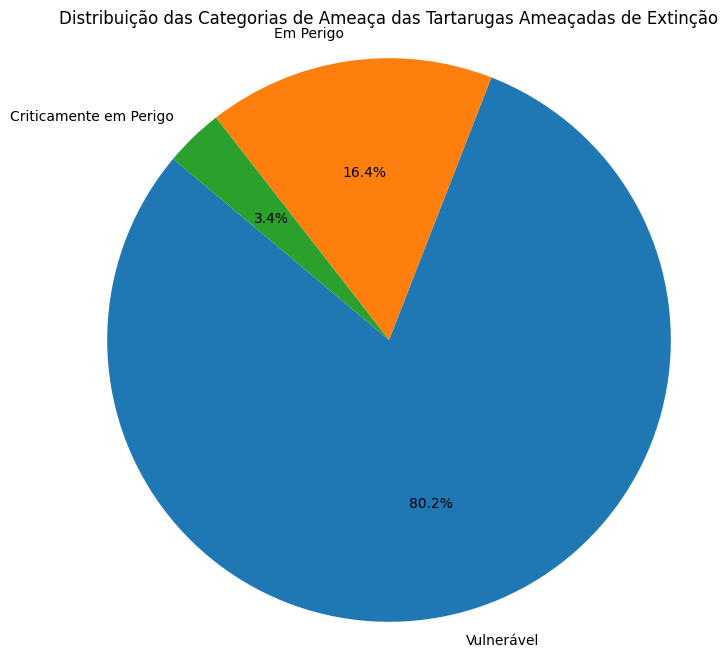

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregue os dados do arquivo CSV
a = pd.read_csv('./registroB.csv', sep=',')

# Conte o número de denúncias por categoria de ameaça
contagem_categoria_ameaca = a['Categoria de Ameaca'].value_counts()

# Extraia as categorias de ameaça como rótulos e as contagens como valores para o gráfico de pizza
labels = contagem_categoria_ameaca.index
sizes = contagem_categoria_ameaca.values

# Crie o gráfico de pizza
plt.figure(figsize=(8, 8))  # Tamanho da figura
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)  # 'autopct' mostra os percentuais nas fatias
plt.title('Distribuição das Categorias de Ameaça das Tartarugas Ameaçadas de Extinção')
plt.axis('equal')  # Deixa o gráfico de pizza circular
plt.show()

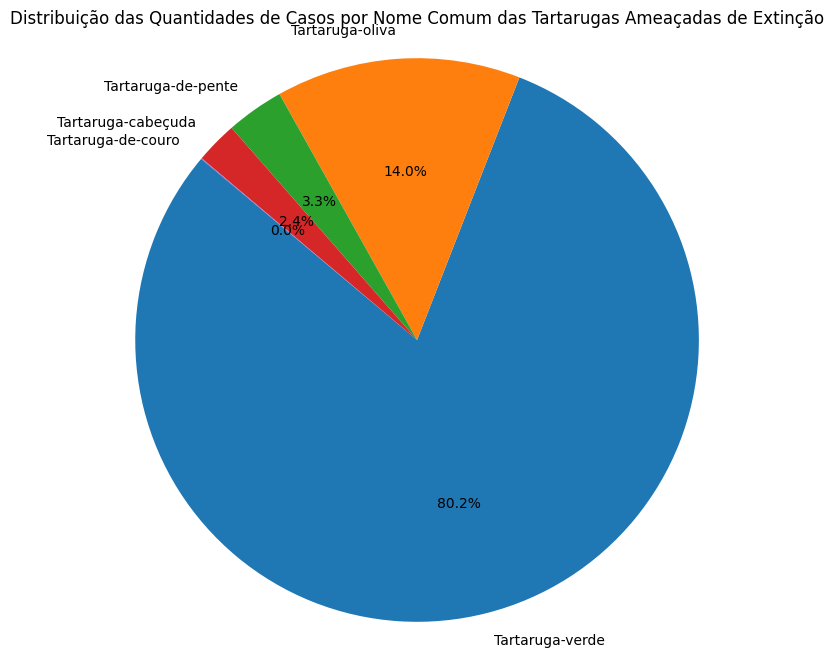

In [217]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregue os dados do arquivo CSV
a = pd.read_csv('./registroB.csv', sep=',')

# Conte o número de casos por nome comum da tartaruga
contagem_nome_comum = a['Nome comum'].value_counts()

# Extraia os nomes comuns como rótulos e as contagens como valores para o gráfico de pizza
labels = contagem_nome_comum.index
sizes = contagem_nome_comum.values

# Crie o gráfico de pizza
plt.figure(figsize=(8, 8))  # Tamanho da figura
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)  # 'autopct' mostra os percentuais nas fatias
plt.title('Distribuição das Quantidades de Casos por Nome Comum das Tartarugas Ameaçadas de Extinção')
plt.axis('equal')  # Deixa o gráfico de pizza circular
plt.show()

In [218]:
import pandas as pd

# Carregar os dados do arquivo 'locais.csv'
locais = pd.read_csv('.\locaisco.csv')

# Função para formatar as coordenadas
def formatar_coordenadas(coordenada):
    # Remove os espaços em branco
    coordenada = coordenada.replace(' ', '')
    
    # Insere o ponto a cada dois números inteiros
    return f"{coordenada[:2]}.{coordenada[2:4]}.{coordenada[4:]}" if len(coordenada) > 3 else coordenada

# Aplica a formatação nas colunas de Latitude e Longitude
locais['Latitude'] = locais['Latitude'].apply(formatar_coordenadas)
locais['Longitude'] = locais['Longitude'].apply(formatar_coordenadas)

# Salva os dados formatados de volta no arquivo 'locais.csv'
locais.to_csv('locais.csv', index=False)

In [219]:
import sys
print(sys.executable)

C:\Users\João Victor\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


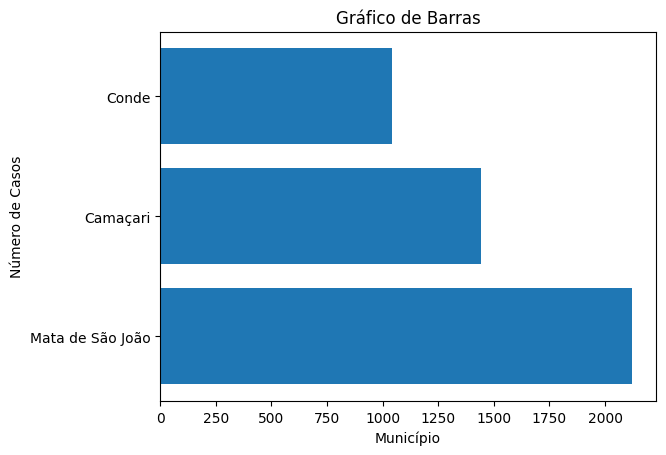

In [220]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregue os dados do arquivo CSV
a = pd.read_csv('./registroB.csv', sep=',')

# Conte o número de casos de cada nome comum
contagem_nome_comum = a['Municipio'].value_counts()

y = contagem_nome_comum.index
x = contagem_nome_comum.values

plt.barh(y, x)  # barras horizontais
plt.xlabel('Município')  # Rótulo do eixo x
plt.ylabel('Número de Casos')  # Rótulo do eixo y
plt.title('Gráfico de Barras')
plt.show()

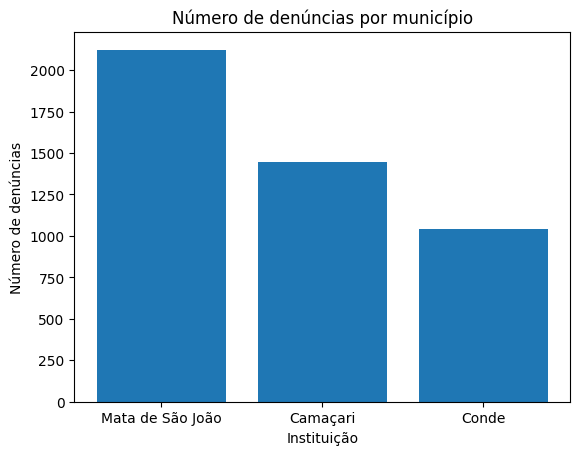

In [221]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregue os dados do arquivo CSV
a = pd.read_csv('./registroB.csv', sep=',')

# Conte o número de denúncias por instituição
contagem = a['Municipio'].value_counts()

x = contagem.index
y = contagem.values

plt.bar(x, y)
plt.xlabel('Instituição')  # Rótulo do eixo x
plt.ylabel('Número de denúncias')  # Rótulo do eixo y
plt.title('Número de denúncias por município')
plt.show()

     Ano                   Nome cientifico          Nome comum  Contagem
0   2012                   Caretta caretta  Tartaruga-cabeçuda        12
1   2012           Chelonia mydas agassizi     Tartaruga-verde      1062
2   2012              Dermochelys coriacea  Tartaruga-de-couro         1
3   2012  Eretmochelys imbricata imbricata  Tartaruga-de-pente        46
4   2012             Lepidochelys olivacea     Tartaruga-oliva       115
5   2013                   Caretta caretta  Tartaruga-cabeçuda        36
6   2013           Chelonia mydas agassizi     Tartaruga-verde       986
7   2013              Dermochelys coriacea  Tartaruga-de-couro         1
8   2013  Eretmochelys imbricata imbricata  Tartaruga-de-pente        59
9   2013             Lepidochelys olivacea     Tartaruga-oliva       197
10  2014                   Caretta caretta  Tartaruga-cabeçuda        27
11  2014           Chelonia mydas agassizi     Tartaruga-verde       835
12  2014  Eretmochelys imbricata imbricata  Tartaru

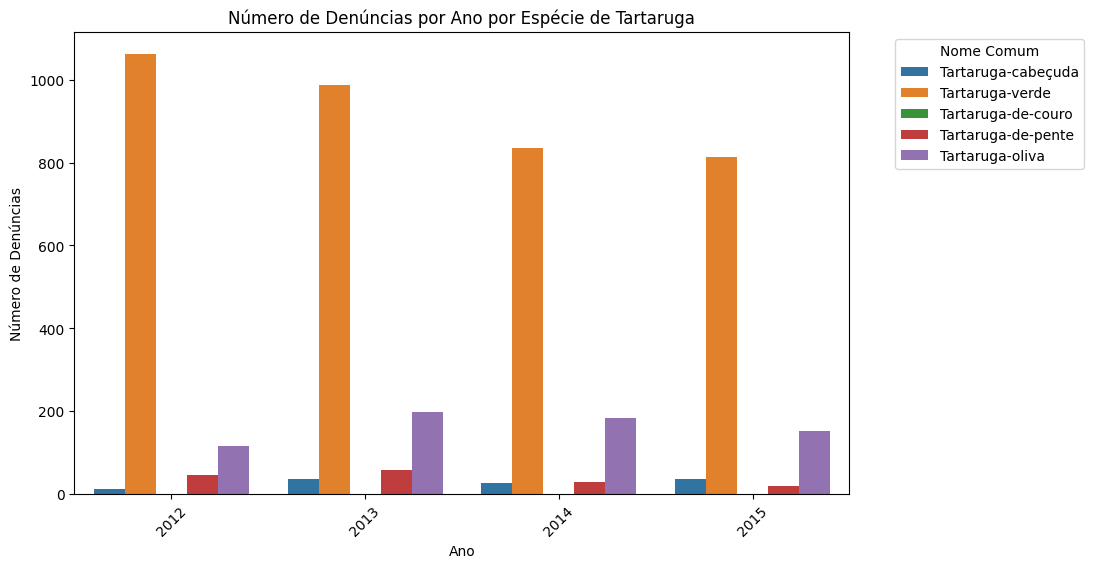

In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Carregue os dados do arquivo CSV
a = pd.read_csv('./registroB.csv', sep=',')

# Extrair o ano da coluna "Data do registro"
a['Ano'] = pd.to_datetime(a['Data do registro'], format='%d/%m/%Y').dt.year

# Agrupar os dados por ano, espécies de tartarugas e "nome comum" e contar o número de denúncias em cada grupo
contagem_por_ano_especie_nome_comum = a.groupby(['Ano', 'Nome cientifico', 'Nome comum']).size().reset_index(name='Contagem')


print(contagem_por_ano_especie_nome_comum)

# Aqui você pode criar o gráfico apropriado com base nos dados agrupados
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Ano', y='Contagem', hue='Nome comum', data=contagem_por_ano_especie_nome_comum)
plt.title('Número de Denúncias por Ano por Espécie de Tartaruga')
plt.xlabel('Ano')
plt.ylabel('Número de Denúncias')
plt.xticks(rotation=45)
plt.legend(title='Nome Comum', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()